In [2]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup 
import re 
import nltk
from nltk.corpus import stopwords

train = pd.read_csv("200Reviews.csv", header=0,
                    delimiter=",")
reviews = train['review']
word_dict = {}
word_dict_reverse = {}
word_index = 0

In [3]:
import nltk.data

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# This function splits a review into sentences
def review_sentences(review, tokenizer, word_dict):
    # 1. Using nltk tokenizer
    raw_sentences = tokenizer.tokenize(review.strip())
    word_index = len(word_dict)
#     print(raw_sentences)
    sentences = []
    # 2. Loop for each sentence
    for raw_sentence in raw_sentences:
        if len(raw_sentence)>0:
             # 2. Removing non-letter.
            review = re.sub("[^a-zA-Z]"," ",review)
            # 3. Converting to lower case and splitting
            words = review.lower().split()
            stops = set(nltk.corpus.stopwords.words("english"))     
            words = [w for w in words if not w in stops]
            
            #adding/labelling words to an index in the dictionary
            for word in words:
                if word not in word_dict.keys():
                    word_dict_reverse[word_index] = word
                    word_dict[word] = word_index
                    word_index += 1
            sentences.append(words)

    # This returns the list of lists
    return sentences

In [7]:
# Creating the model and setting values for the various parameters
num_features = 100  # Word vector dimensionality
min_word_count = 40 # Minimum word count
num_workers = 4     # Number of parallel threads
context = 5        # Context window size
downsampling = 1e-3 # (0.001) Downsample setting for frequent words

# Initializing the train model
from gensim.models import word2vec
print("Training model....")
model = word2vec.Word2Vec(sentences,\
                          workers=num_workers,\
                          size=num_features,\
                          min_count=min_word_count,\
                          window=context,
                          sample=downsampling)

# To make the model memory efficient
model.init_sims(replace=True)

# Saving the model for later use. Can be loaded using Word2Vec.load()
model_name = "300features_40minwords_10context"
model.save(model_name)
print("model saved")


Training model....
model saved


In [6]:
def calculate_occurrence(matrix, sentence, window):
    for i, word in enumerate(sentence):
        word_index = word_dict[word]
        for j in range(max(i-window,0), min(i+window,len(sentence))):
            word_index_other = word_dict[sentence[j]]
            #print(word_index_other)
            matrix[word_index,word_index_other] += 1

In [5]:
def xrange(x):
    return iter(range(x))


import matplotlib.pyplot as plt
from itertools import chain
            
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
# print(type(reviews))
sentences = []

for review in reviews:
    sentences += review_sentences(review, tokenizer, word_dict)
print(word_dict)

{'stuff': 0, 'going': 1, 'moment': 2, 'mj': 3, 'started': 4, 'listening': 5, 'music': 6, 'watching': 7, 'odd': 8, 'documentary': 9, 'watched': 10, 'wiz': 11, 'moonwalker': 12, 'maybe': 13, 'want': 14, 'get': 15, 'certain': 16, 'insight': 17, 'guy': 18, 'thought': 19, 'really': 20, 'cool': 21, 'eighties': 22, 'make': 23, 'mind': 24, 'whether': 25, 'guilty': 26, 'innocent': 27, 'part': 28, 'biography': 29, 'feature': 30, 'film': 31, 'remember': 32, 'see': 33, 'cinema': 34, 'originally': 35, 'released': 36, 'subtle': 37, 'messages': 38, 'feeling': 39, 'towards': 40, 'press': 41, 'also': 42, 'obvious': 43, 'message': 44, 'drugs': 45, 'bad': 46, 'kay': 47, 'br': 48, 'visually': 49, 'impressive': 50, 'course': 51, 'michael': 52, 'jackson': 53, 'unless': 54, 'remotely': 55, 'like': 56, 'anyway': 57, 'hate': 58, 'find': 59, 'boring': 60, 'may': 61, 'call': 62, 'egotist': 63, 'consenting': 64, 'making': 65, 'movie': 66, 'fans': 67, 'would': 68, 'say': 69, 'made': 70, 'true': 71, 'nice': 72, 'ac

In [8]:
matrix = np.zeros([len(word_dict), len(word_dict)])
for sentence in sentences:
    calculate_occurrence(matrix,sentence, 5)

In [9]:
la = np.linalg
U,s,Vh = la.svd(matrix, full_matrices=False)

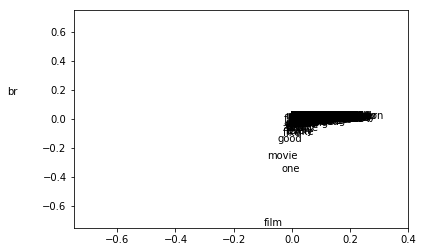

In [10]:
plt.ylim(-0.75,0.75)
plt.xlim(-0.75,0.40)

for i in iter(range(len(word_dict))):
    plt.text(U[i,0],U[i,1],word_dict_reverse.get(i))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


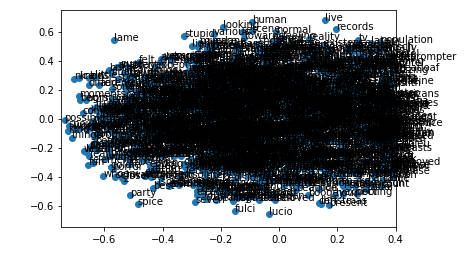

In [11]:
from sklearn.decomposition import PCA
# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
plt.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
	plt.annotate(word, xy=(result[i, 0], result[i, 1]))

plt.ylim(-0.75,0.75)
plt.xlim(-0.75,0.40)
    
plt.show()

In [12]:
import operator
def getMostSimilarWords(word):
    most_similar_words = []
    dot_product_of_words = {}
    for key in embeddings.keys():
        if key != word:
            dot_product_of_words[key] = embeddings[word].dot(embeddings[key])
    sorted_words = sorted(dot_product_of_words.items(), key=operator.itemgetter(1))
    for i in range(9):
#         print(len(sorted_words))
        most_similar_words.append((sorted_words[len(sorted_words)+i-9][0],sorted_words[len(sorted_words)+i-9][1]))
    return most_similar_words

In [14]:
embedded_matrix_hundred = U[0:,:100]
embeddings = {}
for i in range(len(word_dict_reverse)):
    embeddings[word_dict_reverse[i]] = embedded_matrix_hundred[i]

print(len(embeddings))
# print(embedded_matrix)

7001


In [26]:
#Output From SVD


print(getMostSimilarWords('movie'))

[('horror', 0.016354755986701087), ('second', 0.016365496271388766), ('got', 0.016447541320853222), ('since', 0.017126052505081642), ('christ', 0.018242279970538455), ('saw', 0.018266763431641134), ('rest', 0.020205919916742233), ('asian', 0.024695417475784624), ('based', 0.03596741946283205)]


In [27]:
#Output From Word2Vec

model.wv.most_similar("movie")

[('message', 0.8043859004974365),
 ('based', 0.7236683368682861),
 ('unless', 0.7187128067016602),
 ('costumes', 0.6722128987312317),
 ('sound', 0.6661903262138367),
 ('completely', 0.6446002721786499),
 ('grade', 0.6430834531784058),
 ('moments', 0.6407217979431152),
 ('rate', 0.6293487548828125),
 ('casting', 0.6285818815231323)]